# QuantumSim - Grover's Algorithm
Author: Nico Kuijpers<br>
Date: May 11, 2024

This notebook is based on the following notebook from Qiskit, but uses QuantumSim instead of Qiskit.

https://learning.quantum.ibm.com/tutorial/grovers-algorithm

In [1]:
from quantumsim import *

## Introduction
Grover's algorithm requires an *oracle* that specifies one or more marked computational basis states. Here, "marked" means a state with a 
phase of -1. A controlled-Z gate, or its multi-controlled generalization over $N$ qubits, marks the $2^N - 1$ state (or '$1$'$*N$ bit-string).
Marking basis states with one or more '$0$' in the binary representation requires applying X-gates on the corresponding qubits before and after
the controlled-Z gate; equivalent to having an open-control on that qubit. Below, we define an oracle that marks one or more input basis states 
defined by their bit-string representation. 

Note that to construct a multi-controlled Z-gate, a number of elementary gates is required. In QuantumSim, the effect of this gate is
simulated by applying the corresponding unitary operation. The unitary matrix for this operation for a circuit of $N$ qubits is 
the $2^N \times 2^N$ identity matrix, but with $-1$ at entry $(2^N-1,2^N-1)$.

The multi-controlled Z-gate is applied by method call *multi_controlled_pauli_z()* of class Circuit.

In [2]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        Circuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    # Create the circuit
    circuit = Circuit(num_qubits)

    # Mark each target state in the input list
    for target in marked_states:
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if target.startswith("0",ind)]

        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        for i in zero_inds:
            circuit.pauli_x(i)
        circuit.multi_controlled_pauli_z()
        for i in zero_inds:
            circuit.pauli_x(i)

    return circuit

Using the oracle function, a specific instance of Grover search can be created.

In [3]:
def grover_operator(oracle:Circuit):
    grover = Circuit(oracle.N)
    grover.append_circuit(oracle)
    for q in range (grover.N):
        grover.hadamard(q)
    for q in range (grover.N):
        grover.pauli_x(q)
    grover.hadamard(grover.N - 1)
    grover.multi_controlled_pauli_x() 
    grover.hadamard(grover.N - 1)
    for q in range (grover.N):
        grover.pauli_x(q)
    for q in range (grover.N):
        grover.hadamard(q)
    return grover

Repeated applications of the grover_operator circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit. 
There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:

In [4]:
def optimal_num_iterations(marked_states):
    return max(1,math.floor(math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**len(marked_states[0]))))))

In [5]:
def create_grover_circuit(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    nr_iterations = optimal_num_iterations(marked_states)
    oracle = grover_oracle(marked_states)
    circuit = Circuit(oracle.N)
    circuit_grover_operator = grover_operator(oracle)
    for q in range(oracle.N):
        circuit.hadamard(q)
    for i in range(nr_iterations):
        circuit.append_circuit(circuit_grover_operator)
    return circuit

In [6]:
#marked_states = ["00"] # 1 iteration, output correct
#marked_states = ["01"] # 1 iteration, output correct
#marked_states = ["01","10"] # 1 iteration, gives all possible states as output
#marked_states = ["01","10","11"] # 1 iteration, gives output |00>
#marked_states = ["000","111"] # 1 iteration
#marked_states = ["100","101"] # 1 iteration
#marked_states = ["100"] # 2 iterations
#marked_states = ["1010"] # 3 iterations
#marked_states = ["0101","1010"] # 2 iterations
#marked_states = ["0001","0010","0100","1000"] # 1 iteration
#marked_states = ["0000","0001","0011","0111","1111"] # 1 iteration
#marked_states = ["01010","01011","01110","10101"] # 2 iterarations
marked_states = ["01011","10101"] # 3 iterarations
#marked_states = ["01011"] # 4 iterarations

In [7]:
nr_iterations = optimal_num_iterations(marked_states)
print(f"Nr iterations is {nr_iterations} for marked states {marked_states}")

Nr iterations is 3 for marked states ['01011', '10101']


In [8]:
circuit = create_grover_circuit(marked_states)

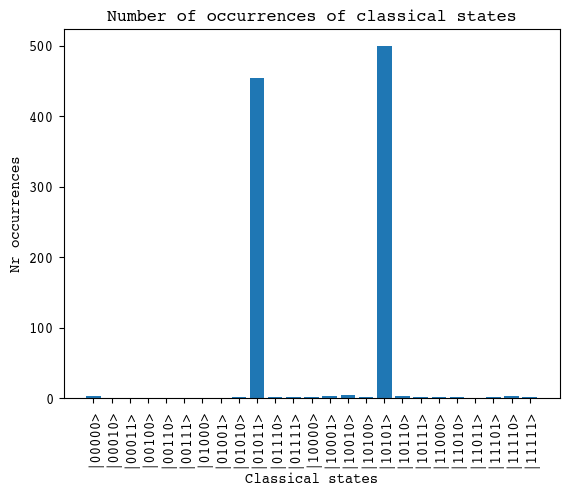

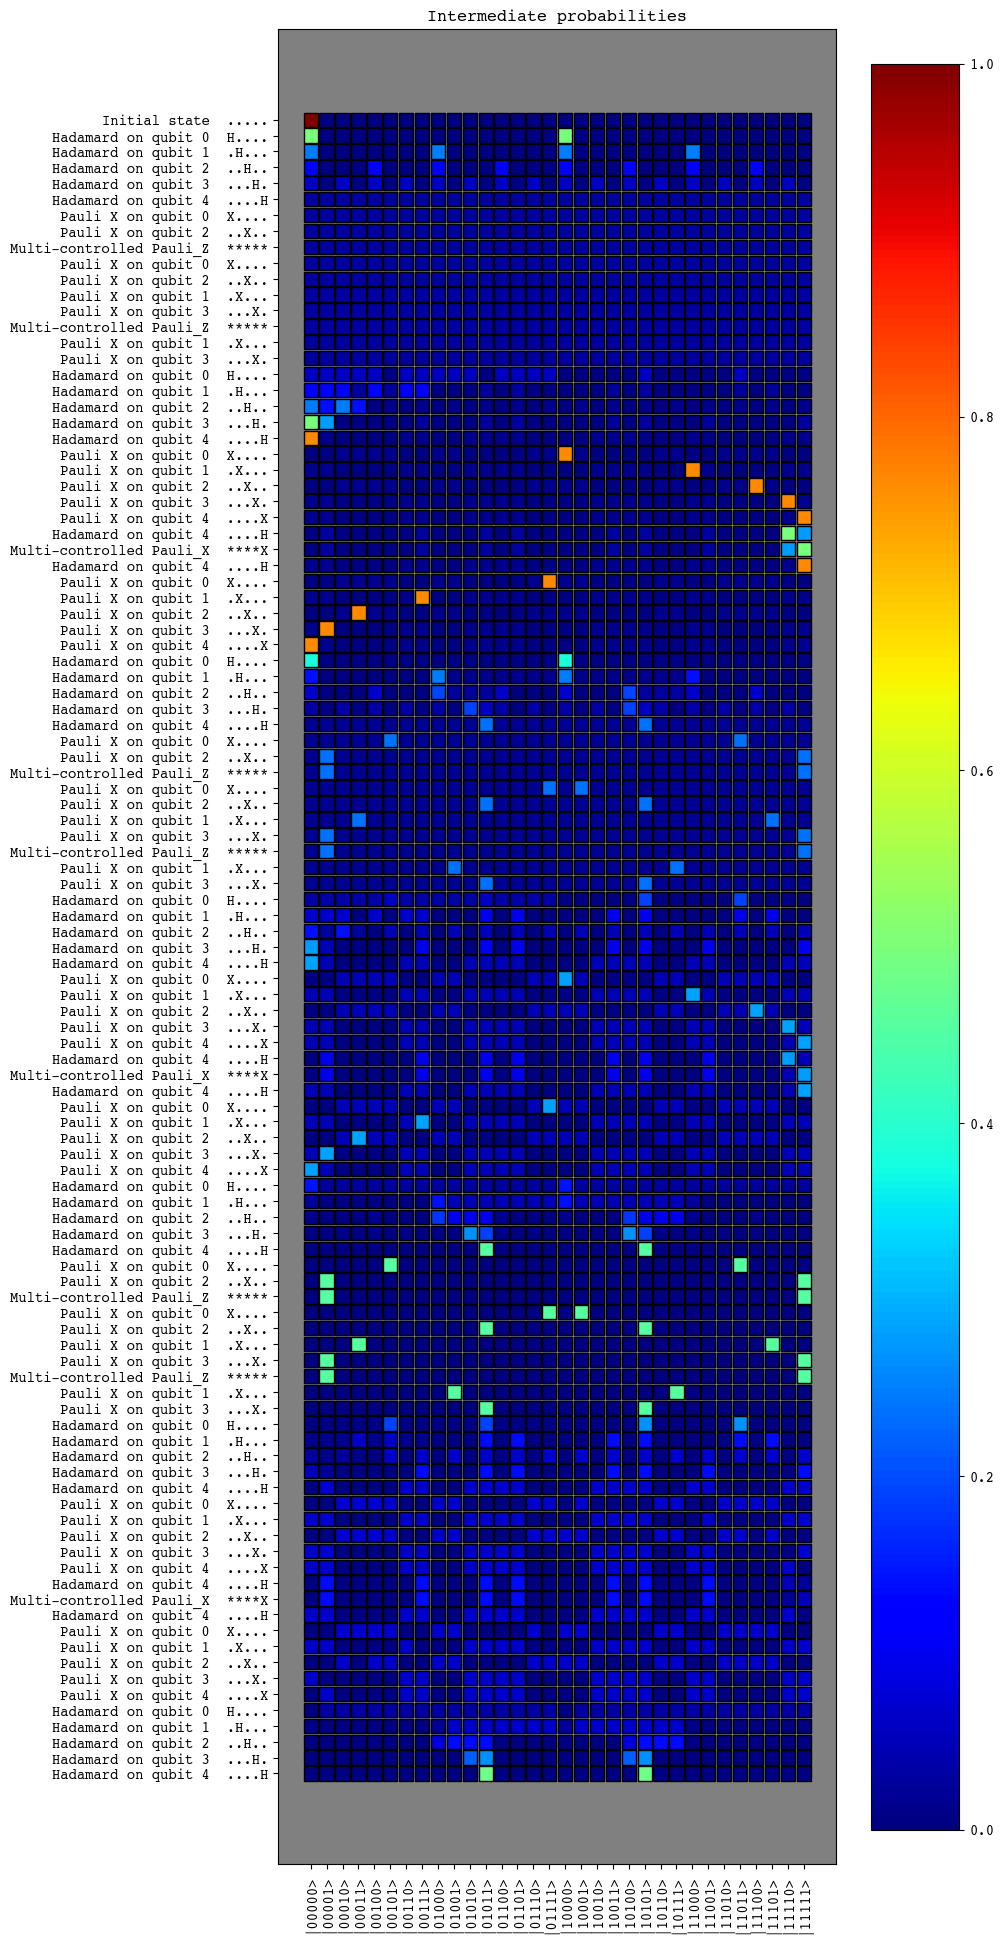

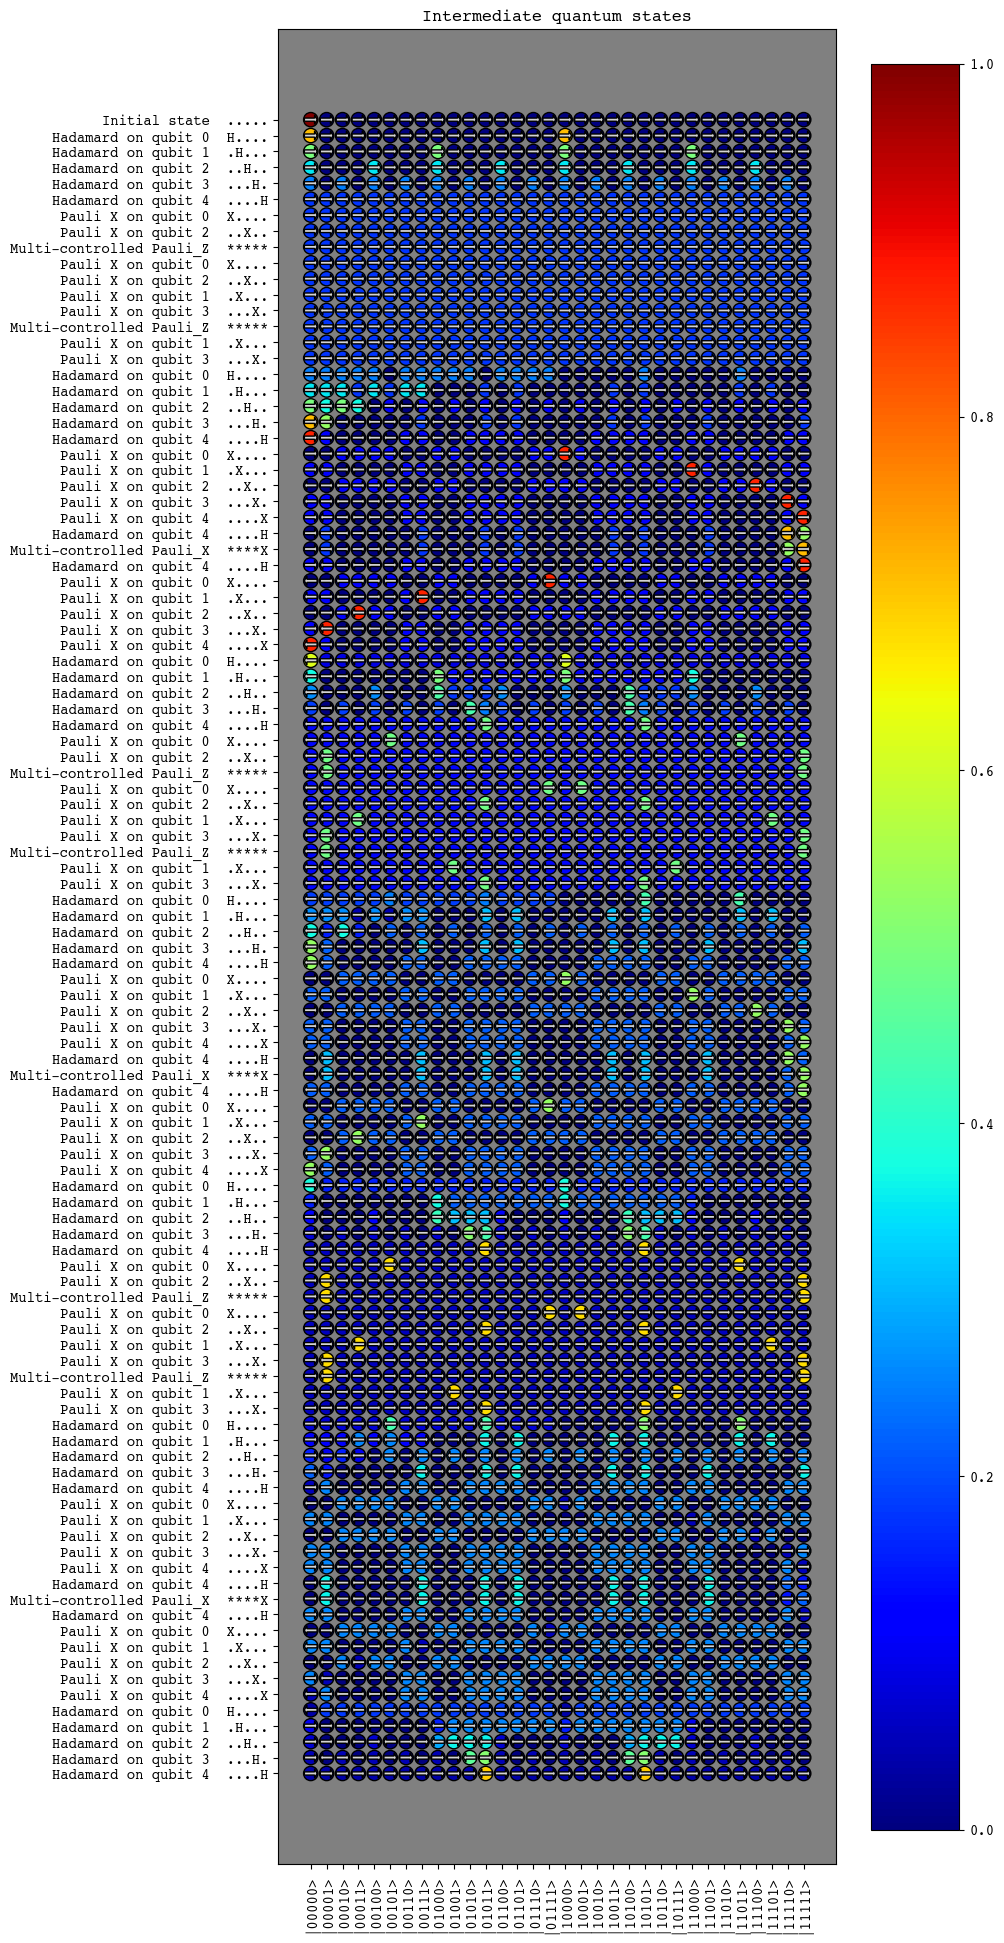

In [9]:
result = QuantumUtil.run_circuit(circuit,nr_runs=1000)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.show_all_probabilities(circuit)
QuantumUtil.show_all_intermediate_states(circuit)